<a href="https://colab.research.google.com/github/AbdullahNasser98/Text_summarization/blob/master/Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install contractions
!pip install rouge
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
## for data
import datasets  #(1.13.3)
import pandas as pd  #(0.25.1)
import numpy  #(1.16.4)
## for plotting
import matplotlib.pyplot as plt  #(3.1.2)
import seaborn as sns  #(0.9.0)
## for preprocessing
import re
import nltk  #(3.4.5)
import contractions  #(0.0.18)
## for textrank
import gensim  #(3.8.1)
## for evaluation
import rouge  #(1.0.0)
import difflib
## for seq2seq
from tensorflow.keras import callbacks, models, layers, preprocessing as kprocessing #(2.6.0)
## for bart
import transformers  #(3.0.1)

In [3]:
## load the full dataset of 300k articles
dataset = datasets.load_dataset("cnn_dailymail", '3.0.0')

Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
lst_dics = [dic for dic in dataset["train"]]
## keep the first N articles if you want to keep it lite
N = 20000 
dtf = pd.DataFrame(lst_dics).rename(columns={"article":"text", 
      "highlights":"y"})[["text","y"]].head(N)
dtf.head()

,text,y
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non..."
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical..."


In [5]:
len(dtf)

20000

In [6]:
i = 1
print("--- Full text ---")
print(dtf["text"][i])
print("--- Summary ---")
print(dtf["y"][i])

--- Full text ---
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less li

In [7]:
###We will use the first record while testing
dtf_train = dtf.iloc[i+1:]
dtf_test = dtf.iloc[:i+1]

In [8]:
########################TextRank#################
'''
Summarizes corpus with TextRank.
:parameter    
    :param corpus: str or list - dtf["text"]    
    :param ratio: length of the summary (ex. 20% of the text)
:return    
    list of summaries
'''
def textrank(corpus, ratio=0.2):    
    if type(corpus) is str:        
       corpus = [corpus]    
    lst_summaries = [gensim.summarization.summarize(txt,  
                     ratio=ratio) for txt in corpus]    
    return lst_summaries

## Apply the function to corpus
predicted = textrank(corpus=dtf_test["text"], ratio=0.2)
predicted[i]

'An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court.\nSo, they end up on the ninth floor severely mentally disturbed, but not getting any real help because they\'re in jail.\nLeifman says about one-third of all people in Miami-Dade county jails are mentally ill.\nLeifman tells me that these prisoner-patients will often circulate through the system, occasionally stabilizing in a mental hospital, only to return to jail to face their charges.\nLeifman says 200 years ago people were considered "lunatics" and they were locked up in jails even if they had no charges against them.\nOver the years, he says, there was some public outcry, and the mentally ill were moved out of jails and into hospitals.\nBut Leifma

In [9]:
###Rouge score to evaluate the result
'''
Calculate ROUGE score.
:parameter    
    :param y_test: string or list    
    :param predicted: string or list
'''
import numpy as np
def evaluate_summary(y_test, predicted):    
   rouge_score = rouge.Rouge()    
   scores = rouge_score.get_scores(y_test, predicted, avg=True)       
   score_1 = round(scores['rouge-1']['f'], 2)    
   score_2 = round(scores['rouge-2']['f'], 2)    
   score_L = round(scores['rouge-l']['f'], 2)    
   print("rouge1:", score_1, "| rouge2:", score_2, "| rougeL:",
         score_2, "--> avg rouge:", round(np.mean(
         [score_1,score_2,score_L]), 2))
## Apply the function to predicted
i = 1
evaluate_summary(dtf_test["y"][i], predicted[i])
'''
unigrams are sequences of 1 words   rouge1
bigrams are sequences of  words     rouge 2
'''

rouge1: 0.21 | rouge2: 0.07 | rougeL: 0.07 --> avg rouge: 0.15


'\nunigrams are sequences of 1 words   rouge1\nbigrams are sequences of  words     rouge 2\n'

In [10]:
'''
Find the matching substrings in 2 strings.
:parameter
    :param a: string - raw text
    :param b: string - raw text
:return
    2 lists used in to display matches
'''
import nltk
nltk.download('punkt')
def utils_split_sentences(a, b):
    ## find clean matches
    match = difflib.SequenceMatcher(isjunk=None, a=a, b=b, autojunk=True)
    lst_match = [block for block in match.get_matching_blocks() if block.size > 20]
    
    ## difflib didn't find any match
    if len(lst_match) == 0:
        lst_a, lst_b = nltk.sent_tokenize(a), nltk.sent_tokenize(b)
    
    ## work with matches
    else:
        first_m, last_m = lst_match[0], lst_match[-1]

        ### a
        string = a[0 : first_m.a]
        lst_a = [t for t in nltk.sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = a[m.a : m.a+m.size]
            lst_a.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = a[m.a+m.size : next_m.a]
                lst_a = lst_a + [t for t in nltk.sent_tokenize(string)]
            else:
                break
        string = a[last_m.a+last_m.size :]
        lst_a = lst_a + [t for t in nltk.sent_tokenize(string)]

        ### b
        string = b[0 : first_m.b]
        lst_b = [t for t in nltk.sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = b[m.b : m.b+m.size]
            lst_b.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = b[m.b+m.size : next_m.b]
                lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
            else:
                break
        string = b[last_m.b+last_m.size :]
        lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
    
    return lst_a, lst_b


'''
Highlights the matched strings in text.
:parameter
    :param a: string - raw text
    :param b: string - raw text
    :param both: bool - search a in b and, if True, viceversa
    :param sentences: bool - if False matches single words
:return
    text html, it can be visualized on notebook with display(HTML(text))
'''
def display_string_matching(a, b, both=True, sentences=True, titles=[]):
    if sentences is True:
        lst_a, lst_b = utils_split_sentences(a, b)
    else:
        lst_a, lst_b = a.split(), b.split()       
    
    ## highlight a
    first_text = []
    for i in lst_a:
        if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_b]:
            first_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
        else:
            first_text.append(i)
    first_text = ' '.join(first_text)
    
    ## highlight b
    second_text = []
    if both is True:
        for i in lst_b:
            if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_a]:
                second_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
            else:
                second_text.append(i)
    else:
        second_text.append(b) 
    second_text = ' '.join(second_text)
    
    ## concatenate
    if len(titles) > 0:
        first_text = "<strong>"+titles[0]+"</strong><br>"+first_text
    if len(titles) > 1:
        second_text = "<strong>"+titles[1]+"</strong><br>"+second_text
    else:
        second_text = "---"*65+"<br><br>"+second_text
    final_text = first_text +'<br><br>'+ second_text
    return final_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
match = display_string_matching(dtf_test["y"][i], predicted[i], both=True, sentences=False, titles=["Real Summary", "Predicted Summary"])
from IPython.core.display import display, HTML
display(HTML(match))

In [12]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from collections import Counter
## create stopwords
lst_stopwords = nltk.corpus.stopwords.words("english")
## add words that are too frequent
#lst_stopwords = lst_stopwords + ["cnn","say","said","new"]

## cleaning function
def utils_preprocess_text(txt, punkt=True, lower=True, slang=True, lst_stopwords=None, stemm=False, lemm=True):
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt) if punkt is True else txt
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower() if lower is True else txt
    ### slang
    txt = contractions.fix(txt) if slang is True else txt   
    ### tokenize (convert from string to list)
    lst_txt = txt.split()
    ### stemming (remove -ing, -ly, ...)
    if stemm is True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]
    ### lemmatization (convert the word into root word)
    if lemm is True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]
    ### remove Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in 
                   lst_stopwords]
    ### back to string
    txt = " ".join(lst_txt)
    return txt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:

## apply function to both text and summaries
dtf_train["text_clean"] = dtf_train["text"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, 
                                                                                  slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))
dtf_train["y_clean"] = dtf_train["y"].apply(lambda x: utils_preprocess_text(x, punkt=True, 
                                                                            lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [14]:

## apply function to both text and summaries
dtf_test["text_clean"] = dtf_test["text"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, 
                                                                                  slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))
dtf_test["y_clean"] = dtf_test["y"].apply(lambda x: utils_preprocess_text(x, punkt=True, 
                                                                            lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [15]:
dtf_train.head()

,text,y,text_clean,y_clean
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",minneapolis minnesota cnn driver minneapolis b...,new thought wa going die driver say man say pi...
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",washington cnn doctor removed five small polyp...,five small polyp found procedure none worrisom...
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",cnn national football league ha indefinitely s...,new nfl chief atlanta falcon owner critical mi...
5,"BAGHDAD, Iraq (CNN) -- Dressed in a Superman s...","Parents beam with pride, can't stop from smili...",baghdad iraq cnn dressed superman shirt 5yearo...,parent beam pride cannot stop smiling outpouri...
6,"BAGHDAD, Iraq (CNN) -- The women are too afrai...","Aid workers: Violence, increased cost of livin...",baghdad iraq cnn woman afraid ashamed show fac...,aid worker violence increased cost living driv...


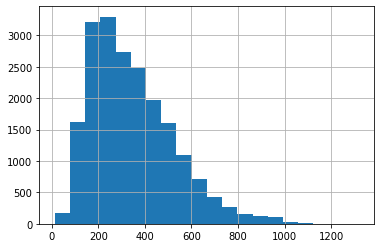

In [16]:
###Text max length distribution
seq_len = [len(i.split()) for i in dtf_train["text_clean"]]
pd.Series(seq_len).hist(bins = 20)

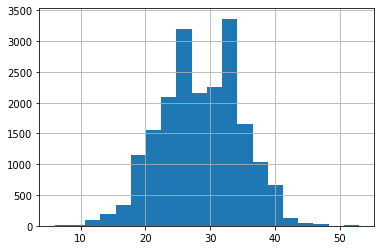

In [17]:
###summary max length distribution
seq_len = [len(i.split()) for i in dtf_train["y_clean"]]
pd.Series(seq_len).hist(bins = 20)

In [18]:
X_len = 400
y_len = 50

In [19]:
from collections import Counter
print('Most common words in text')
p = Counter(" ".join(dtf_train["text_clean"]).split()).most_common(10)
rslt = pd.DataFrame(p, columns=['Word', 'Frequency'])
print(rslt)

print('')
print('Most common words in summary')
p = Counter(" ".join(dtf_train["y_clean"]).split()).most_common(10)
rslt = pd.DataFrame(p, columns=['Word', 'Frequency'])
print(rslt)

Most common words in text
     Word  Frequency
0    said     119736
1      wa      95690
2      ha      47434
3     cnn      33766
4  people      29488
5     one      29367
6    year      27962
7   would      24998
8     say      23194
9    time      21527

Most common words in summary
       Word  Frequency
0       say      12039
1       new       5501
2        wa       5419
3        ha       4154
4      year       2237
5    people       2076
6    police       1962
7  official       1889
8       one       1836
9       two       1764


In [24]:
'''
Summarizes corpus with Bart.
:parameter    
   :param corpus: list - dtf["text"]    
   :param max_len: length of the summary
:return    
    list of summaries
'''

def bart(corpus, max_len):    
    nlp = transformers.pipeline("summarization")    
    lst_summaries = [nlp(txt, min_length=39, max_length=max_len)[0]["summary_text"].replace(" .", ".")                    
                     for txt in corpus]    
    return lst_summaries

## Apply the function to corpus
predicted = bart(corpus=dtf_test["text"], max_len=100)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


In [27]:
i=0
match = display_string_matching(dtf_test["y"][i], predicted[i], both=True, sentences=False, titles=["Real Summary", "Predicted Summary"])
from IPython.core.display import display, HTML
display(HTML(match))